In [ ]:
import numpy as np
import pandas as pd
import cv2
#%matplotlib notebook
import matplotlib.pyplot as plt
import os
#from scipy.ndimage.filters import convolve 
from scipy.ndimage import filters
from multiprocessing import Pool
import random
import time as tm

In [ ]:
'''global octaves 
global s 
global k 
global sigma 
#global array_of_img

octaves = 3
s = 3
k = 2**(1.0/s)
sigma = 1.25
contrastThreshold = 256 * 0.03
num_attempt = 5
ratio = 10
radius_factor = 3
buns = 36
peak_ratio = 0.8
tolerance = 1e-7
#array_of_img = [] # Store all the image dataarray_of_img = [] # Store all the image data'''

'global octaves \nglobal s \nglobal k \nglobal sigma \n#global array_of_img\n\noctaves = 3\ns = 3\nk = 2**(1.0/s)\nsigma = 1.25\ncontrastThreshold = 256 * 0.03\nnum_attempt = 5\nratio = 10\nradius_factor = 3\nbuns = 36\npeak_ratio = 0.8\ntolerance = 1e-7\n#array_of_img = [] # Store all the image dataarray_of_img = [] # Store all the image data'

In [ ]:
'''def gaussian_filter(sigma):
    size = 2*np.ceil(3*sigma)+1 
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g =  np.exp(-((x**2 + y**2)/(2.0*sigma**2)))/(2.0*np.pi*sigma**2)
    return g/g.sum() #normalize'''


'def gaussian_filter(sigma):\n    size = 2*np.ceil(3*sigma)+1 \n    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]\n    g =  np.exp(-((x**2 + y**2)/(2.0*sigma**2)))/(2.0*np.pi*sigma**2)\n    return g/g.sum() #normalize'

In [ ]:
'''def generate_octave(init_level, s, sigma, c): 
    octave = [] 
    for i in range(s+3): 
        next_level = filters.gaussian_filter(init_level, (k**i) * c *sigma).astype(np.int32)
        octave.append(next_level) 
    return octave'''


'def generate_octave(init_level, s, sigma, c): \n    octave = [] \n    for i in range(s+3): \n        next_level = filters.gaussian_filter(init_level, (k**i) * c *sigma).astype(np.int32)\n        octave.append(next_level) \n    return octave'

In [ ]:
'''def generate_gaussian_pyramid(img, sigma): 
    pyr = [] 
    tmp_img = img
    h = tmp_img.shape[0]
    w = tmp_img.shape[1]
    for i in range(octaves): 
        order = 1 - i
        size = 2**order
        c = 2 ** i
        im = cv2.resize(tmp_img.astype(np.uint8), (int(w*size),int(h*size)), interpolation=cv2.INTER_AREA)
        octave = generate_octave(im, s, sigma, c) 
        pyr.append(octave) 
        tmp_img = octave[-1]
    return pyr
'''

'def generate_gaussian_pyramid(img, sigma): \n    pyr = [] \n    tmp_img = img\n    h = tmp_img.shape[0]\n    w = tmp_img.shape[1]\n    for i in range(octaves): \n        order = 1 - i\n        size = 2**order\n        c = 2 ** i\n        im = cv2.resize(tmp_img.astype(np.uint8), (int(w*size),int(h*size)), interpolation=cv2.INTER_AREA)\n        octave = generate_octave(im, s, sigma, c) \n        pyr.append(octave) \n        tmp_img = octave[-1]\n    return pyr\n'

In [ ]:
'''def generate_DoG(pyr):
    DoG_pyr = []
    for i in range(octaves):
        tmp = []
        for j in range(s+2):
            tmp.append(pyr[i][j+1] - pyr[i][j])
            #plt.figure()
            #plt.imshow((pyr[i][j+1] - pyr[i][j]),cmap = 'gray'))
        DoG_pyr.append(tmp)
    return DoG_pyr'''

"def generate_DoG(pyr):\n    DoG_pyr = []\n    for i in range(octaves):\n        tmp = []\n        for j in range(s+2):\n            tmp.append(pyr[i][j+1] - pyr[i][j])\n            #plt.figure()\n            #plt.imshow((pyr[i][j+1] - pyr[i][j]),cmap = 'gray'))\n        DoG_pyr.append(tmp)\n    return DoG_pyr"

In [ ]:
'''def select_key(top,middle,down):
    #print(top.shape)
    #print(middle.shape)
    #print(down.shape)
    if np.all(middle[1, 1] >= top) \
        and np.all(middle[1, 1] >= down) \
        and np.all(middle[1, 1] >= middle[0,:]) \
        and np.all(middle[1, 1] >= middle[2,:]) \
        and (middle[1, 1] >= middle[1, 0]) \
        and (middle[1, 1] >= middle[1, 2]):
        return True
    elif np.all(middle[1, 1] <= top) \
        and np.all(middle[1, 1] <= down) \
        and np.all(middle[1, 1] <= middle[0,:]) \
        and np.all(middle[1, 1] <= middle[2,:]) \
        and (middle[1, 1] <= middle[1, 0]) \
        and (middle[1, 1] <= middle[1, 2]):
        return True
    else:
        return False'''

'def select_key(top,middle,down):\n    #print(top.shape)\n    #print(middle.shape)\n    #print(down.shape)\n    if np.all(middle[1, 1] >= top)         and np.all(middle[1, 1] >= down)         and np.all(middle[1, 1] >= middle[0,:])         and np.all(middle[1, 1] >= middle[2,:])         and (middle[1, 1] >= middle[1, 0])         and (middle[1, 1] >= middle[1, 2]):\n        return True\n    elif np.all(middle[1, 1] <= top)         and np.all(middle[1, 1] <= down)         and np.all(middle[1, 1] <= middle[0,:])         and np.all(middle[1, 1] <= middle[2,:])         and (middle[1, 1] <= middle[1, 0])         and (middle[1, 1] <= middle[1, 2]):\n        return True\n    else:\n        return False'

In [ ]:
'''def Gradient(top,middle,down):
    #top = top.astype('float32')/255.
    #middle = middle.astype('float32')/255.
    #down = down.astype('float32')/255.
    
    dx = (middle[2, 1]-middle[0, 1])/2.0
    dy = (middle[1, 2]-middle[1, 0])/2.0
    ds = (top[1, 1]-down[1, 1])/2.0
    
    return np.array([dx,dy,ds])'''

"def Gradient(top,middle,down):\n    #top = top.astype('float32')/255.\n    #middle = middle.astype('float32')/255.\n    #down = down.astype('float32')/255.\n    \n    dx = (middle[2, 1]-middle[0, 1])/2.0\n    dy = (middle[1, 2]-middle[1, 0])/2.0\n    ds = (top[1, 1]-down[1, 1])/2.0\n    \n    return np.array([dx,dy,ds])"

In [ ]:
'''def Hessian(top,middle,down):
    #top = top.astype('float32')/255.
    #middle = middle.astype('float32')/255.
    #down = down.astype('float32')/255.
    
    dxx = middle[2, 1] - 2*middle[1, 1] + middle[0, 1]
    dyy = middle[1, 2] - 2*middle[1, 1] + middle[1, 0]
    dss = top[1, 1] - 2*middle[1, 1] + down[1, 1]
    
    dxy = 0.25 * (middle[2, 2] - middle[2, 0] - middle[0, 2] + middle[0, 0])
    dxs = 0.25 * (top[2, 1] - top[0, 1] - down[2, 1] + down[0, 1])
    dys = 0.25 * (top[1, 2] - top[1, 0] - down[1, 2] + down[1, 0])
    
    return np.array([[dxx,dxy,dxs],
                     [dxy,dyy,dys],
                     [dxs,dys,dss]])'''

"def Hessian(top,middle,down):\n    #top = top.astype('float32')/255.\n    #middle = middle.astype('float32')/255.\n    #down = down.astype('float32')/255.\n    \n    dxx = middle[2, 1] - 2*middle[1, 1] + middle[0, 1]\n    dyy = middle[1, 2] - 2*middle[1, 1] + middle[1, 0]\n    dss = top[1, 1] - 2*middle[1, 1] + down[1, 1]\n    \n    dxy = 0.25 * (middle[2, 2] - middle[2, 0] - middle[0, 2] + middle[0, 0])\n    dxs = 0.25 * (top[2, 1] - top[0, 1] - down[2, 1] + down[0, 1])\n    dys = 0.25 * (top[1, 2] - top[1, 0] - down[1, 2] + down[1, 0])\n    \n    return np.array([[dxx,dxy,dxs],\n                     [dxy,dyy,dys],\n                     [dxs,dys,dss]])"

In [ ]:
'''def orientaion_key(gaussian_img,octave,s,x,y,w,h): #x,y keypoint
    keypoints_orientaion = []
    scale = 1.5 *(2**(1-octave))
    radius = int(np.round(radius_factor * scale))
    weight_factor = -0.5  / (scale**2)
    raw_hist = np.zeros(buns)
    smooth_hist = np.zeros(buns)
    
    
    for i in range(-radius, radius+1):
        y_region = y + i
        if y_region > 0 and y_region < w-1:
            for j in range(-radius, radius+1):
                x_region = x + j
                if x_region > 0 and x_region < h-1:
                    dx = gaussian_img[x_region-1,y_region] - gaussian_img[x_region+1,y_region] #img x axis go down
                    dy = gaussian_img[x_region,y_region+1] - gaussian_img[x_region,y_region-1]
                    gradient_mag = np.sqrt(dx*dx+dy*dy)
                    gradient_ori = np.rad2deg(np.arctan2(dx,dy)) #img x y change axis
                    weight = np.exp(weight_factor * (i**2+j**2))
                    hist_index = int(np.round(gradient_ori * buns / 360.))
                    raw_hist[hist_index%buns] += weight*gradient_mag
                    
    for n in range(buns):
        smooth_hist[n] = (6*raw_hist[n]+ 4*(raw_hist[n-1] + raw_hist[(n+1)%buns]) + (raw_hist[n-2] + raw_hist[(n+2)%buns])) / 16.
    ori_max = np.max(smooth_hist)
    ori_peaks = np.where(np.logical_and((smooth_hist > np.roll(smooth_hist,1)),(smooth_hist > np.roll(smooth_hist,-1))))[0]
    ori_max_2nd = 0
    for peak_index in ori_peaks:
        peak_value = smooth_hist[peak_index]
        if (peak_value <= ori_max) and (peak_value > ori_max_2nd):
            ori_max_2nd = peak_value
    for peak_index in ori_peaks:
        peak_value = smooth_hist[peak_index]        
        if (peak_value >= peak_ratio * ori_max) and (peak_value >= ori_max_2nd):
            left = smooth_hist[(peak_index-1)%buns]
            right = smooth_hist[(peak_index+1)%buns]
            interpolated_index = (peak_index + 0.5 * (left-right)/(left - 2*peak_value + right)) % buns
            ori = 360. - interpolated_index * 360./buns
            if abs(ori - 360.) < tolerance:
                ori = 0
            keypoints_orientaion.append((s,octave,x,y,ori,w,h))  
    return keypoints_orientaion  '''

'def orientaion_key(gaussian_img,octave,s,x,y,w,h): #x,y keypoint\n    keypoints_orientaion = []\n    scale = 1.5 *(2**(1-octave))\n    radius = int(np.round(radius_factor * scale))\n    weight_factor = -0.5  / (scale**2)\n    raw_hist = np.zeros(buns)\n    smooth_hist = np.zeros(buns)\n    \n    \n    for i in range(-radius, radius+1):\n        y_region = y + i\n        if y_region > 0 and y_region < w-1:\n            for j in range(-radius, radius+1):\n                x_region = x + j\n                if x_region > 0 and x_region < h-1:\n                    dx = gaussian_img[x_region-1,y_region] - gaussian_img[x_region+1,y_region] #img x axis go down\n                    dy = gaussian_img[x_region,y_region+1] - gaussian_img[x_region,y_region-1]\n                    gradient_mag = np.sqrt(dx*dx+dy*dy)\n                    gradient_ori = np.rad2deg(np.arctan2(dx,dy)) #img x y change axis\n                    weight = np.exp(weight_factor * (i**2+j**2))\n                    hist_index =

In [ ]:
'''def keypoint(DoG_pyr,pyr):
    keys = [] 
    final_keys_lst = []
    for i in range(octaves):
        tmp = []
        for j in range(1,s+1-3+1):
            w = DoG_pyr[i][j+1].shape[1]
            h = DoG_pyr[i][j+1].shape[0]
            #print(w)
            #print(h)
            im = np.zeros((h,w))
            for y_cube in range(1,w-1):
                for x_cube in range(1,h-1):
                    #print(DoG_pyr[i][j+3].shape)
                    x = x_cube
                    y = y_cube
                    index = j
                    outofbound = False
                    update = False
                    if select_key((DoG_pyr[i][index+2])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index+1])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index])[x-1:x+2,y-1:y+2]):
                        #im[x,y] = 1
                        gradient = Gradient((DoG_pyr[i][index+2])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index+1])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index])[x-1:x+2,y-1:y+2])
                        hessian = Hessian((DoG_pyr[i][index+2])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index+1])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index])[x-1:x+2,y-1:y+2])
                        xmax = - np.linalg.lstsq(hessian,gradient,rcond=None)[0]
                        D = (DoG_pyr[i][index+1])[x,y] + 0.5 * np.dot(gradient,xmax)
                        if (abs(D) < contrastThreshold):
                            continue
                        if (abs(xmax[0]) >= 0.5) or (abs(xmax[1]) >= 0.5) or (abs(xmax[2]) >= 0.5):
                            x = x + int(np.round(xmax[0]))
                            y = y + int(np.round(xmax[1]))
                            index = index + int(np.round(xmax[2]))
                            update = True
                            if update and ((x <= 0) or (x>= h-1) or (y <= 0) or (y>= w-1) or (index >= s+1-3+1) or (index < 1)):
                                outofbound = True
                                continue
                        if update:
                            gradient = Gradient((DoG_pyr[i][index+2])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index+1])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index])[x-1:x+2,y-1:y+2])
                            hessian = Hessian((DoG_pyr[i][index+2])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index+1])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index])[x-1:x+2,y-1:y+2])
                            xmax = - np.linalg.lstsq(hessian,gradient,rcond=None)[0]
                            D = (DoG_pyr[i][index+1])[x,y] + 0.5 * np.dot(gradient,xmax)
                        if (not outofbound) and (abs(D) >= contrastThreshold): 
                            #trace = np.trace(hessian[:2,:2])
                            trace = (hessian[0,0] + hessian[1,1])
                            det = (hessian[0,0] * hessian[1,1]) - (hessian[0,1])**2
                            if (det > 0) and ((trace**2 / det) < ((ratio+1)**2 / ratio)):
                                if im[x,y] == 0:
                                    im[x,y] = 1
                                    final_keys = orientaion_key(pyr[i][index],i,index,x,y,w,h)
                                    final_keys_lst.append(final_keys)
            tmp.append(im)
        keys.append(tmp)
    return keys, final_keys_lst
    #return final_keys_lst'''

'def keypoint(DoG_pyr,pyr):\n    keys = [] \n    final_keys_lst = []\n    for i in range(octaves):\n        tmp = []\n        for j in range(1,s+1-3+1):\n            w = DoG_pyr[i][j+1].shape[1]\n            h = DoG_pyr[i][j+1].shape[0]\n            #print(w)\n            #print(h)\n            im = np.zeros((h,w))\n            for y_cube in range(1,w-1):\n                for x_cube in range(1,h-1):\n                    #print(DoG_pyr[i][j+3].shape)\n                    x = x_cube\n                    y = y_cube\n                    index = j\n                    outofbound = False\n                    update = False\n                    if select_key((DoG_pyr[i][index+2])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index+1])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index])[x-1:x+2,y-1:y+2]):\n                        #im[x,y] = 1\n                        gradient = Gradient((DoG_pyr[i][index+2])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index+1])[x-1:x+2,y-1:y+2],(DoG_pyr[i][index])[x-1:x+2,y-1:y+2])\n                       

In [ ]:
'''def SIFT_descriptor(final_keys_lst,pyr,window_width=4, num_bins = 8 ,descirptor_max_value = 0.2,half_sample_pixel=8):
    desciptors = []
    keyp = []
    for key in final_keys_lst:
        octave = key[0][1]
        s = key[0][0]
        scale = 1.5 *(2**(1-octave))
        w = key[0][5]
        h = key[0][6]
        ori = key[0][4]
        theta = np.deg2rad(360.- ori)
        x = key[0][2]
        y = key[0][3]
        hist = np.zeros((window_width**2,num_bins))
        weight_factor = -0.5 / ((0.5*window_width)**2)
        gaussian_img = pyr[octave][s]
        
        for i in range(-half_sample_pixel, half_sample_pixel):#row
            for j in range(-half_sample_pixel, half_sample_pixel):#col
                sin_value = np.sin(theta)
                cos_value = np.cos(theta)
                x_r = int((sin_value * j) + (cos_value * i) + x)
                y_r = int((cos_value * j) - (sin_value * i) + y)
                r_bin = (i+half_sample_pixel)%window_width
                c_bin = (j+half_sample_pixel)%window_width
                
                if x_r > 0 and x_r < h-1 and y_r > 0 and y_r < w-1:
                    dx = gaussian_img[x_r-1,y_r] - gaussian_img[x_r+1,y_r] #img x axis go down
                    dy = gaussian_img[x_r,y_r+1] - gaussian_img[x_r,y_r-1]
                    gradient_mag = np.sqrt(dx*dx+dy*dy)
                    gradient_ori = np.rad2deg(np.arctan2(dx,dy)) #img x y change axis
                    weight = np.exp(weight_factor * (r_bin**2+c_bin**2))
                    hist_index = int(np.round(gradient_ori * num_bins / 360.))
                    hist[((i+8)//4)*window_width+(j+8)//4][hist_index%num_bins] += weight*gradient_mag
                    
        hist = hist/np.linalg.norm(hist)
        np.clip(hist, 0, 0.2)
        hist = hist/np.linalg.norm(hist)
        new_x = int(x* 2**(-1+octave))
        new_y = int(y* 2**(-1+octave))
        #desciptors.append((new_x,new_y,hist.flatten()))
        desciptors.append(hist.flatten())
        keyp.append((new_x,new_y)) 
        
    return keyp, desciptors'''

'def SIFT_descriptor(final_keys_lst,pyr,window_width=4, num_bins = 8 ,descirptor_max_value = 0.2,half_sample_pixel=8):\n    desciptors = []\n    keyp = []\n    for key in final_keys_lst:\n        octave = key[0][1]\n        s = key[0][0]\n        scale = 1.5 *(2**(1-octave))\n        w = key[0][5]\n        h = key[0][6]\n        ori = key[0][4]\n        theta = np.deg2rad(360.- ori)\n        x = key[0][2]\n        y = key[0][3]\n        hist = np.zeros((window_width**2,num_bins))\n        weight_factor = -0.5 / ((0.5*window_width)**2)\n        gaussian_img = pyr[octave][s]\n        \n        for i in range(-half_sample_pixel, half_sample_pixel):#row\n            for j in range(-half_sample_pixel, half_sample_pixel):#col\n                sin_value = np.sin(theta)\n                cos_value = np.cos(theta)\n                x_r = int((sin_value * j) + (cos_value * i) + x)\n                y_r = int((cos_value * j) - (sin_value * i) + y)\n                r_bin = (i+half_sample_pixel)%windo

In [ ]:
'''def matchkeypoint(desciptors_a,desciptors_b,ratio=0.6):
    match_IdxAndDist = []
    for i in range(len(desciptors_a)):
        min_IdxDis = [-1, np.inf]
        min2nd_IdxDis = [-1, np.inf]
        for j in range(len(desciptors_b)):
            feature_a = desciptors_a[i][2]
            feature_b = desciptors_b[j][2]
            dist = np.linalg.norm(feature_a-feature_b)
            if (min_IdxDis[1] > dist):
                min2nd_IdxDis = np.copy(min_IdxDis)
                min_IdxDis = [j, dist]
            elif (min2nd_IdxDis[1] > dist and min2nd_IdxDis[1] != min_IdxDis[1]):
                min_IdxDis = [j, dist]
                
        match_IdxAndDist.append([min_IdxDis[0],min_IdxDis[1],min2nd_IdxDis[0],min2nd_IdxDis[1]])
           
    good_matches = []
    for i in range(len(match_IdxAndDist)):
        if (match_IdxAndDist[i][1] <= match_IdxAndDist[i][3] * ratio):
             good_matches.append((i,match_IdxAndDist[i][0]))
                
    good_match_pos = []
    for (idx, correspondinx) in good_matches:
        psA = (desciptors_a[idx][1],desciptors_a[idx][0])
        psB = (desciptors_b[correspondinx][1],desciptors_b[correspondinx][0])
        good_match_pos.append((psA,psB))
        
    return good_match_pos'''

'def matchkeypoint(desciptors_a,desciptors_b,ratio=0.6):\n    match_IdxAndDist = []\n    for i in range(len(desciptors_a)):\n        min_IdxDis = [-1, np.inf]\n        min2nd_IdxDis = [-1, np.inf]\n        for j in range(len(desciptors_b)):\n            feature_a = desciptors_a[i][2]\n            feature_b = desciptors_b[j][2]\n            dist = np.linalg.norm(feature_a-feature_b)\n            if (min_IdxDis[1] > dist):\n                min2nd_IdxDis = np.copy(min_IdxDis)\n                min_IdxDis = [j, dist]\n            elif (min2nd_IdxDis[1] > dist and min2nd_IdxDis[1] != min_IdxDis[1]):\n                min_IdxDis = [j, dist]\n                \n        match_IdxAndDist.append([min_IdxDis[0],min_IdxDis[1],min2nd_IdxDis[0],min2nd_IdxDis[1]])\n           \n    good_matches = []\n    for i in range(len(match_IdxAndDist)):\n        if (match_IdxAndDist[i][1] <= match_IdxAndDist[i][3] * ratio):\n             good_matches.append((i,match_IdxAndDist[i][0]))\n                \n    good_m

In [ ]:
'''def solve_homography(P,m):
    
    #P coordinate original
    #m coordinate target

    #return H homography matrix
    
    A = []
    for r in range(len(P)):
        A.append([-P[r,0],-P[r,1],-1,0,0,0, P[r,0]*m[r,0], P[r,1]*m[r,0], m[r,0]])
        A.append([0,0,0,-P[r,0],-P[r,1],-1, P[r,0]*m[r,1], P[r,1]*m[r,1], m[r,1]])

    u, s, vt = np.linalg.svd(A)
    H = np.reshape(vt[8], (3,3))
    H = (1/H.item(8)) * H

    return H '''               

'def solve_homography(P,m):\n    \n    #P coordinate original\n    #m coordinate target\n\n    #return H homography matrix\n    \n    A = []\n    for r in range(len(P)):\n        A.append([-P[r,0],-P[r,1],-1,0,0,0, P[r,0]*m[r,0], P[r,1]*m[r,0], m[r,0]])\n        A.append([0,0,0,-P[r,0],-P[r,1],-1, P[r,0]*m[r,1], P[r,1]*m[r,1], m[r,1]])\n\n    u, s, vt = np.linalg.svd(A)\n    H = np.reshape(vt[8], (3,3))\n    H = (1/H.item(8)) * H\n\n    return H '

In [ ]:
'''def fitHomoMat(matches_pos, threshold = 5.0, numiter = 1000, numrandomsubsample = 4):
    dstPoints = []
    srcPoints = []
    for dstPoint, srcPoint in matches_pos:
        dstPoints.append(list(dstPoint))
        srcPoints.append(list(srcPoint))

    dstPoints = np.array(dstPoints)
    srcPoints = np.array(srcPoints)

    Numsample = len(matches_pos)
    #threshold = 5.0
    #numiter = 1000
    #numrandomsubsample = 4
    maxinliner = 0
    best_H = None

    for run in range(numiter):
        subsampleidx = random.sample(range(Numsample),numrandomsubsample)
        H = solve_homography(srcPoints[subsampleidx],dstPoints[subsampleidx])

        numinlier = 0
        for i in range(Numsample):
            if i not in subsampleidx:
                concatecoor = np.hstack((srcPoints[i],1))
                dstcoor = H @ concatecoor.T
                if dstcoor[2] <= 1e-8:
                    continue
                dstcoor = dstcoor / dstcoor[2]
                if (np.linalg.norm(dstcoor[:2] - dstPoints[i]) < threshold):
                    numinlier = numinlier + 1
        if (maxinliner < numinlier):
            maxinliner = numinlier
            best_H = H

    print('Num of max inlier: ',maxinliner)

    return best_H'''

"def fitHomoMat(matches_pos, threshold = 5.0, numiter = 1000, numrandomsubsample = 4):\n    dstPoints = []\n    srcPoints = []\n    for dstPoint, srcPoint in matches_pos:\n        dstPoints.append(list(dstPoint))\n        srcPoints.append(list(srcPoint))\n\n    dstPoints = np.array(dstPoints)\n    srcPoints = np.array(srcPoints)\n\n    Numsample = len(matches_pos)\n    #threshold = 5.0\n    #numiter = 1000\n    #numrandomsubsample = 4\n    maxinliner = 0\n    best_H = None\n\n    for run in range(numiter):\n        subsampleidx = random.sample(range(Numsample),numrandomsubsample)\n        H = solve_homography(srcPoints[subsampleidx],dstPoints[subsampleidx])\n\n        numinlier = 0\n        for i in range(Numsample):\n            if i not in subsampleidx:\n                concatecoor = np.hstack((srcPoints[i],1))\n                dstcoor = H @ concatecoor.T\n                if dstcoor[2] <= 1e-8:\n                    continue\n                dstcoor = dstcoor / dstcoor[2]\n           

In [ ]:
def linearBlendingWithConstantWidth(img_left, img_right, constant_width = 3):
        '''
        linear Blending with Constat Width, avoiding ghost region
        # you need to determine the size of constant with
        '''
        (hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        img_left_mask = np.zeros((hr, wr), dtype="int")
        img_right_mask = np.zeros((hr, wr), dtype="int")
        
        # find the left image and right image mask region(Those not zero pixels)
        '''for i in range(hl):
            for j in range(wl):
                if np.count_nonzero(img_left[i, j]) > 0:
                    img_left_mask[i, j] = 1'''
        for i in range(hl):
            for j in range(wl):
                img_left_mask[i, j] = 1
                    
        for i in range(hr):
            for j in range(wr):
                if np.count_nonzero(img_right[i, j]) > 0:
                    img_right_mask[i, j] = 1
                    
        # find the overlap mask(overlap region of two image)
        overlap_mask = np.zeros((hr, wr), dtype="int")
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(img_left_mask[i, j]) > 0 and np.count_nonzero(img_right_mask[i, j]) > 0):
                    overlap_mask[i, j] = 1
        
        # compute the alpha mask to linear blending the overlap region
        alpha_mask = np.zeros((hr, wr)) # alpha value depend on left image
        for i in range(hr):
            minIdx = maxIdx = -1
            for j in range(wr):
                if (overlap_mask[i, j] == 1 and minIdx == -1):
                    minIdx = j
                if (overlap_mask[i, j] == 1):
                    maxIdx = j
            
            if (minIdx == maxIdx): # represent this row's pixels are all zero, or only one pixel not zero
                continue
                
            decrease_step = 1 / (maxIdx - minIdx)
            
            # Find the middle line of overlapping regions, and only do linear blending to those regions very close to the middle line.
            middleIdx = int((maxIdx + minIdx) / 2)
            
            # left 
            for j in range(minIdx, middleIdx + 1):
                if (j >= middleIdx - constant_width):
                    alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
                    '''elif not np.count_nonzero(img_left[i, j]) > 0 :
                        alpha_mask[i, j] = 0'''
                else:
                    alpha_mask[i, j] = 1
            # right
            for j in range(middleIdx + 1, maxIdx + 1):
                if (j <= middleIdx + constant_width):
                    alpha_mask[i, j] = 1 - (decrease_step * (j - minIdx))
                else:
                    alpha_mask[i, j] = 0

        
        linearBlendingWithConstantWidth_img = np.copy(img_right)
        linearBlendingWithConstantWidth_img[:hl, :wl] = np.copy(img_left)
        # linear blending with constant width
        for i in range(hr):
            for j in range(wr):
                if (np.count_nonzero(overlap_mask[i, j]) > 0):
                    linearBlendingWithConstantWidth_img[i, j] = alpha_mask[i, j] * img_left[i, j] + (1 - alpha_mask[i, j]) * img_right[i, j]
        
        return linearBlendingWithConstantWidth_img, middleIdx

In [ ]:
def removeBlackBorder(img):
        '''
        Remove img's the black border 
        '''
        h, w = img.shape[:2]
        reduced_h, reduced_w = h, w
        # right to left
        for col in range(w - 1, -1, -1):
            all_black = True
            for i in range(h):
                if (np.count_nonzero(img[i, col]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                reduced_w = reduced_w - 1
                
        # bottom to top 
        for row in range(h - 1, -1, -1):
            all_black = True
            for i in range(reduced_w):
                if (np.count_nonzero(img[row, i]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                reduced_h = reduced_h - 1
        
        return img[:reduced_h, :reduced_w]

In [ ]:
'''def findBlackBorder2wrap(img):
    h, w = img.shape[:2]
    top_right, down_right = (0, w-1), (h-1, w-1)
    # right to left
    subimg = np.float32(img)
    gray = cv2.cvtColor(subimg,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    print(dst)
    dilate = cv2.dilate(dst,None)
    subimg[dilate>0.05*dilate.max()]=[0,0,255]
    plt.figure()
    plt.imshow(subimg[:,:,::-1].astype(int))'''
    

'def findBlackBorder2wrap(img):\n    h, w = img.shape[:2]\n    top_right, down_right = (0, w-1), (h-1, w-1)\n    # right to left\n    subimg = np.float32(img)\n    gray = cv2.cvtColor(subimg,cv2.COLOR_BGR2GRAY)\n    gray = np.float32(gray)\n    dst = cv2.cornerHarris(gray,2,3,0.04)\n    print(dst)\n    dilate = cv2.dilate(dst,None)\n    subimg[dilate>0.05*dilate.max()]=[0,0,255]\n    plt.figure()\n    plt.imshow(subimg[:,:,::-1].astype(int))'

In [ ]:
def warp(img_left, img_right, best_H):
    
        '''(hl, wl) = img_left.shape[:2]
        (hr, wr) = img_right.shape[:2]
        stitch_img = np.zeros( (max(hl, hr), wl + wr, 3), dtype="int")
           
        # Transform Right image(the coordination of right image) to destination iamge(the coordination of left image) with HomoMat
        inv_H = np.linalg.inv(best_H)
        for i in range(stitch_img.shape[0]):
            for j in range(stitch_img.shape[1]):
                coor = np.array([j, i, 1])
                img_right_coor = inv_H @ coor # the coordination of right image
                img_right_coor /= img_right_coor[2]
                
                # you can try like nearest neighbors or interpolation  
                y, x = int(round(img_right_coor[0])), int(round(img_right_coor[1])) # y for width, x for height
                
                
                # if the computed coordination not in the (hegiht, width) of right image, it's not need to be process 
                if (x < 0 or x >= hr or y < 0 or y >= wr):
                    continue
                # else we need the tranform for this pixel
                stitch_img[i, j] = img_right[x, y]'''
        val = img_left.shape[1] + img_right.shape[1]
        stitch_img = cv2.warpPerspective(img_right, best_H, (val , img_left.shape[0]))
        
        plt.figure()
        plt.imshow((stitch_img * 255).astype(np.uint8))
        '''
        plt.figure()
        tmp = removeBlackBorder(stitch_img)
        plt.imshow(tmp)'''
                
        middleIdx = 0
        stitch_img, middleIdx = linearBlendingWithConstantWidth(img_left, stitch_img)
        
        # remove the black border
        stitch_img = removeBlackBorder(stitch_img)
        
        return stitch_img, middleIdx

In [ ]:
'''def final_description(im):
    #print(im.shape)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    pyr = generate_gaussian_pyramid(gray, sigma)
    DoG_pyr = generate_DoG(pyr)
    keys, final_keys_lst = keypoint(DoG_pyr,pyr)
    keyp, desciptors = SIFT_descriptor(final_keys_lst,pyr)
    return (keyp, desciptors)'''

'def final_description(im):\n    #print(im.shape)\n    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)\n    pyr = generate_gaussian_pyramid(gray, sigma)\n    DoG_pyr = generate_DoG(pyr)\n    keys, final_keys_lst = keypoint(DoG_pyr,pyr)\n    keyp, desciptors = SIFT_descriptor(final_keys_lst,pyr)\n    return (keyp, desciptors)'

In [ ]:
# Read directory function
def read_directory(directory_name):
    array_of_img = []
    filenumber = len([name for name in os.listdir(directory_name) if os.path.isfile(os.path.join(directory_name, name))])
    for i in range(1,filenumber+1):
        print(directory_name + "/" + str(i)+".jpg")
        img = cv2.imread(directory_name + "/" + str(i)+".jpg")
        array_of_img.append(img)
        #print(img.shape)
        #print(type(img))
    return array_of_img

In [ ]:
def cylindricalwarp(img, K):
    h_, w_ = img.shape[:2]
    y_i, x_i = np.indices((h_, w_))
    X = np.stack([x_i, y_i, np.ones_like(x_i)],axis = -1).reshape(h_*w_,3)
    Kinv = np.linalg.inv(K)
    X = Kinv.dot(X.T).T
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T
    B = B[:,:-1] / B[:,[-1]]
    B[(B[:,0] < 0)|(B[:,0] >= w_)|(B[:,1] < 0)|(B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA)
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32),B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode = cv2.BORDER_TRANSPARENT)

In [ ]:
'''img = cv2.imread('parrington/6.jpg')
print(img.shape)
plt.figure()
plt.imshow(img[:,:,::-1])
h, w = img.shape[:2]
f = 1000
K=np.array([[f,0,w/2],[0,f,h/2],[0,0,1]])
img_cyl = cylindricalwarp(img, K)
plt.figure()
print(img_cyl.shape)
i = cv2.cvtColor(img_cyl,cv2.COLOR_BGRA2BGR)[:,:,::-1].astype(int)
plt.imshow(i)
print(i.shape)'''

"img = cv2.imread('parrington/6.jpg')\nprint(img.shape)\nplt.figure()\nplt.imshow(img[:,:,::-1])\nh, w = img.shape[:2]\nf = 1000\nK=np.array([[f,0,w/2],[0,f,h/2],[0,0,1]])\nimg_cyl = cylindricalwarp(img, K)\nplt.figure()\nprint(img_cyl.shape)\ni = cv2.cvtColor(img_cyl,cv2.COLOR_BGRA2BGR)[:,:,::-1].astype(int)\nplt.imshow(i)\nprint(i.shape)"

In [ ]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2]) 
    return frame

In [ ]:
def start(dirname):
    print('start imshow')
    t = tm.localtime()
    current_time = tm.strftime("%H:%M:%S", t)
    print(current_time)
    imageout=SIFT(dirname)
    plt.figure()
    plt.imshow(trim(imageout[:,:,::-1].astype(int)))
    cv2.imwrite(dirname+'.jpg', imageout.astype(int))
    print('finish')
    t = tm.localtime()
    current_time = tm.strftime("%H:%M:%S", t)
    print(current_time)

In [ ]:
'''f = open('testfile.txt', 'r')
dirname = str(f.readline()).strip()
while(dirname): 
    print('start imshow')
    t = tm.localtime()
    current_time = tm.strftime("%H:%M:%S", t)
    print(current_time)
    imageout=SIFT(dirname)
    plt.figure()
    plt.imshow(trim(imageout[:,:,::-1].astype(int)))
    cv2.imwrite(dirname+'.jpg', imageout.astype(int))
    print('finish')
    t = tm.localtime()
    current_time = tm.strftime("%H:%M:%S", t)
    print(current_time)
    dirname = str(f.readline()).strip()'''

'f = open(\'testfile.txt\', \'r\')\ndirname = str(f.readline()).strip()\nwhile(dirname): \n    print(\'start imshow\')\n    t = tm.localtime()\n    current_time = tm.strftime("%H:%M:%S", t)\n    print(current_time)\n    imageout=SIFT(dirname)\n    plt.figure()\n    plt.imshow(trim(imageout[:,:,::-1].astype(int)))\n    cv2.imwrite(dirname+\'.jpg\', imageout.astype(int))\n    print(\'finish\')\n    t = tm.localtime()\n    current_time = tm.strftime("%H:%M:%S", t)\n    print(current_time)\n    dirname = str(f.readline()).strip()'

In [ ]:
'''# save the stitched iamge
saveFilePath = "wrap.jpg"
cv2.imwrite(saveFilePath, warp_img)'''

'# save the stitched iamge\nsaveFilePath = "wrap.jpg"\ncv2.imwrite(saveFilePath, warp_img)'

In [ ]:
'''img1 = cv2.imread('parrington/1.jpg') 
descri1 = final_description(img1)
img2 = cv2.imread('parrington/2.jpg')
descri2 = final_description(img2)
img3 = cv2.imread('parrington/3.jpg')
descri3 = final_description(img3)
good_match_pos = matchkeypoint(descri1,descri2)
good_match_pos2 = matchkeypoint(descri2,descri3)
homo = fitHomoMat(good_match_pos)
homo2 = fitHomoMat(good_match_pos2)'''

"img1 = cv2.imread('parrington/1.jpg') \ndescri1 = final_description(img1)\nimg2 = cv2.imread('parrington/2.jpg')\ndescri2 = final_description(img2)\nimg3 = cv2.imread('parrington/3.jpg')\ndescri3 = final_description(img3)\ngood_match_pos = matchkeypoint(descri1,descri2)\ngood_match_pos2 = matchkeypoint(descri2,descri3)\nhomo = fitHomoMat(good_match_pos)\nhomo2 = fitHomoMat(good_match_pos2)"

In [ ]:
'''#warp_img, center_line = warp(img1, img2, homo)
#warp_img2, center_line = warp(warp_img, img3, homo2@homo)
warp_img,middleIdx = warp(img1, img2, homo)
plt.figure()
plt.title("warp_img")
plt.imshow(warp_img[:,:,::-1].astype(int))

descri2 = final_description(np.float32(warp_img[:,middleIdx:]))
good_match_pos2 = matchkeypoint(descri2,descri3)
homo2 = fitHomoMat(good_match_pos2)
warp_img2,middleIdx2 = warp(warp_img[:,middleIdx:], img3, homo2)
plt.figure()
plt.title("warp_img2")
plt.imshow(warp_img2[:,:,::-1].astype(int))
for n in range(warp_img[:,:middleIdx,:].shape[1], warp_img2.shape[1]):
    if max(warp_img2[0:int(warp_img2.shape[0]/3),n,0]) == 0 and max(warp_img2[0:int(warp_img2.shape[0]/3),n,1]) == 0 and max(warp_img2[0:int(warp_img2.shape[0]/3),n,2]) == 0:
        break
    elif max(warp_img2[int(2*warp_img2.shape[0]/3):,n,0]) == 0 and max(warp_img2[int(2*warp_img2.shape[0]/3):,n,1]) == 0 and max(warp_img2[int(2*warp_img2.shape[0]/3):,n,2]) == 0:
        break
imageoutput = np.concatenate(( warp_img[:,:middleIdx,:],warp_img2[0:warp_img[:,:middleIdx,:].shape[0], 0:n,:]), axis=1)
plt.figure()
plt.title("imageoutput")
plt.imshow(imageoutput[:,:,::-1].astype(int))'''

'#warp_img, center_line = warp(img1, img2, homo)\n#warp_img2, center_line = warp(warp_img, img3, homo2@homo)\nwarp_img,middleIdx = warp(img1, img2, homo)\nplt.figure()\nplt.title("warp_img")\nplt.imshow(warp_img[:,:,::-1].astype(int))\n\ndescri2 = final_description(np.float32(warp_img[:,middleIdx:]))\ngood_match_pos2 = matchkeypoint(descri2,descri3)\nhomo2 = fitHomoMat(good_match_pos2)\nwarp_img2,middleIdx2 = warp(warp_img[:,middleIdx:], img3, homo2)\nplt.figure()\nplt.title("warp_img2")\nplt.imshow(warp_img2[:,:,::-1].astype(int))\nfor n in range(warp_img[:,:middleIdx,:].shape[1], warp_img2.shape[1]):\n    if max(warp_img2[0:int(warp_img2.shape[0]/3),n,0]) == 0 and max(warp_img2[0:int(warp_img2.shape[0]/3),n,1]) == 0 and max(warp_img2[0:int(warp_img2.shape[0]/3),n,2]) == 0:\n        break\n    elif max(warp_img2[int(2*warp_img2.shape[0]/3):,n,0]) == 0 and max(warp_img2[int(2*warp_img2.shape[0]/3):,n,1]) == 0 and max(warp_img2[int(2*warp_img2.shape[0]/3):,n,2]) == 0:\n        break\nim

In [ ]:
'''warp_img,middleIdx = warp(img1, img2, homo)
plt.figure()
plt.title("warp_img")
plt.imshow(warp_img[:,:,::-1].astype(int))
for n in range(img1.shape[1], warp_img.shape[1]):
    if max(warp_img[0:int(warp_img.shape[0]/3),n,0]) == 0 and max(warp_img[0:int(warp_img.shape[0]/3),n,1]) == 0 and max(warp_img[0:int(warp_img.shape[0]/3),n,2]) == 0:
        break
    elif max(warp_img[int(2*warp_img.shape[0]/3):,n,0]) == 0 and max(warp_img[int(2*warp_img.shape[0]/3):,n,1]) == 0 and max(warp_img[int(2*warp_img.shape[0]/3):,n,2]) == 0:
        break
#imageoutput = np.concatenate(( img1[:,:middleIdx,:],warp_img[0:img1[:,:middleIdx,:].shape[0], 0:n,:]), axis=1)
plt.figure()
plt.title("imageoutput")
plt.imshow(warp_img[0:img1[:,:middleIdx,:].shape[0], 0:n,:][:,:,::-1].astype(int))'''

'warp_img,middleIdx = warp(img1, img2, homo)\nplt.figure()\nplt.title("warp_img")\nplt.imshow(warp_img[:,:,::-1].astype(int))\nfor n in range(img1.shape[1], warp_img.shape[1]):\n    if max(warp_img[0:int(warp_img.shape[0]/3),n,0]) == 0 and max(warp_img[0:int(warp_img.shape[0]/3),n,1]) == 0 and max(warp_img[0:int(warp_img.shape[0]/3),n,2]) == 0:\n        break\n    elif max(warp_img[int(2*warp_img.shape[0]/3):,n,0]) == 0 and max(warp_img[int(2*warp_img.shape[0]/3):,n,1]) == 0 and max(warp_img[int(2*warp_img.shape[0]/3):,n,2]) == 0:\n        break\n#imageoutput = np.concatenate(( img1[:,:middleIdx,:],warp_img[0:img1[:,:middleIdx,:].shape[0], 0:n,:]), axis=1)\nplt.figure()\nplt.title("imageoutput")\nplt.imshow(warp_img[0:img1[:,:middleIdx,:].shape[0], 0:n,:][:,:,::-1].astype(int))'

In [ ]:
'''plt.figure()
plt.title("imageoutput")
plt.imshow(warp_img[0:img1[:,:middleIdx,:].shape[0], 0:n,:][:,:,::-1].astype(int))'''

'plt.figure()\nplt.title("imageoutput")\nplt.imshow(warp_img[0:img1[:,:middleIdx,:].shape[0], 0:n,:][:,:,::-1].astype(int))'

In [ ]:
'''def drawmatches(img_left, img_right):
    print('-------------a---------------')
    imga = cv2.imread(img_left)
    graya = cv2.cvtColor(imga, cv2.COLOR_BGR2GRAY)
    print('start pyr')
    pyra = generate_gaussian_pyramid(graya, sigma)
    print('start DoG')
    DoG_pyra = generate_DoG(pyra)
    print('start keypoint')
    keysa, final_keys_lsta = keypoint(DoG_pyra,pyra)
    print('start describe')
    desciptors_a = SIFT_descriptor(final_keys_lsta,pyra)
    
    print('-------------b---------------')
    imgb = cv2.imread(img_right)
    grayb = cv2.cvtColor(imgb, cv2.COLOR_BGR2GRAY)
    print('start pyr')
    pyrb = generate_gaussian_pyramid(grayb, sigma)
    print('start DoG')
    DoG_pyrb = generate_DoG(pyrb)
    print('start keypoint')
    keysb, final_keys_lstb = keypoint(DoG_pyrb,pyrb)
    print('start describe')
    desciptors_b = SIFT_descriptor(final_keys_lstb,pyrb)
    
    print('-------------start matching---------------')
    good_match_pos = matchkeypoint(desciptors_a,desciptors_b,ratio=0.8)
    global gmp
    gmp = good_match_pos
    (hl,wl) = imga.shape[:2]
    (hr,wr) = imgb.shape[:2]
    vis = np.zeros((max(hl,hr),wl+wr,3),dtype='uint8')
    vis[0:hl,0:wl] = imga
    vis[0:hr,wl:] = imgb
    print('-------------start draw---------------')
    num = 0
    for (img_left_pos, img_right_pos) in good_match_pos:
        pos_l = img_left_pos[1],img_left_pos[0]
        pos_r = img_right_pos[1] + wl, img_right_pos[0]
        cv2.circle(vis, pos_l, 3, (0,0,255), 1)
        cv2.circle(vis, pos_r, 3, (0,255,0), 1)
        cv2.line(vis, pos_l, pos_r, (255,0,0), 1)
        num = num + 1
        #if num == 100:
        #    break
    print('-------------start imshow---------------')    
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 300    
    plt.figure()
    plt.imshow(vis[:,:,::-1])'''

"def drawmatches(img_left, img_right):\n    print('-------------a---------------')\n    imga = cv2.imread(img_left)\n    graya = cv2.cvtColor(imga, cv2.COLOR_BGR2GRAY)\n    print('start pyr')\n    pyra = generate_gaussian_pyramid(graya, sigma)\n    print('start DoG')\n    DoG_pyra = generate_DoG(pyra)\n    print('start keypoint')\n    keysa, final_keys_lsta = keypoint(DoG_pyra,pyra)\n    print('start describe')\n    desciptors_a = SIFT_descriptor(final_keys_lsta,pyra)\n    \n    print('-------------b---------------')\n    imgb = cv2.imread(img_right)\n    grayb = cv2.cvtColor(imgb, cv2.COLOR_BGR2GRAY)\n    print('start pyr')\n    pyrb = generate_gaussian_pyramid(grayb, sigma)\n    print('start DoG')\n    DoG_pyrb = generate_DoG(pyrb)\n    print('start keypoint')\n    keysb, final_keys_lstb = keypoint(DoG_pyrb,pyrb)\n    print('start describe')\n    desciptors_b = SIFT_descriptor(final_keys_lstb,pyrb)\n    \n    print('-------------start matching---------------')\n    good_match_pos = m

In [ ]:
#drawmatches('parrington/1.jpg', 'parrington/2.jpg') #12/13 17:59

In [ ]:
'''imga = cv2.imread('parrington/2.jpg')
imgb = cv2.imread('parrington/3.jpg')
(hl,wl) = imga.shape[:2]
(hr,wr) = imgb.shape[:2]
vis = np.zeros((max(hl,hr),wl+wr,3),dtype='uint8')
vis[0:hl,0:wl] = imga
vis[0:hr,wl:] = imgb
print('-------------start draw---------------')
num = 0
for (img_left_pos, img_right_pos) in gmp:
    #pos_l = img_left_pos
    #pos_r = img_right_pos[0] + wl, img_right_pos[1]
    pos_l = img_left_pos[1],img_left_pos[0]
    pos_r = img_right_pos[1] + wl, img_right_pos[0]
    cv2.circle(vis, pos_l, 3, (0,0,255), 1)
    cv2.circle(vis, pos_r, 3, (0,255,0), 1)
    cv2.line(vis, pos_l, pos_r, (255,0,0), 1)
    num = num + 1
    #if num == 25:
    #    break
print('-------------start imshow---------------')    
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300    
plt.figure()
plt.imshow(vis[:,:,::-1])'''

"imga = cv2.imread('parrington/2.jpg')\nimgb = cv2.imread('parrington/3.jpg')\n(hl,wl) = imga.shape[:2]\n(hr,wr) = imgb.shape[:2]\nvis = np.zeros((max(hl,hr),wl+wr,3),dtype='uint8')\nvis[0:hl,0:wl] = imga\nvis[0:hr,wl:] = imgb\nprint('-------------start draw---------------')\nnum = 0\nfor (img_left_pos, img_right_pos) in gmp:\n    #pos_l = img_left_pos\n    #pos_r = img_right_pos[0] + wl, img_right_pos[1]\n    pos_l = img_left_pos[1],img_left_pos[0]\n    pos_r = img_right_pos[1] + wl, img_right_pos[0]\n    cv2.circle(vis, pos_l, 3, (0,0,255), 1)\n    cv2.circle(vis, pos_r, 3, (0,255,0), 1)\n    cv2.line(vis, pos_l, pos_r, (255,0,0), 1)\n    num = num + 1\n    #if num == 25:\n    #    break\nprint('-------------start imshow---------------')    \nimport matplotlib as mpl\nmpl.rcParams['figure.dpi'] = 300    \nplt.figure()\nplt.imshow(vis[:,:,::-1])"

In [ ]:
'''img = cv2.imread('parrington/3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pyr = generate_gaussian_pyramid(gray, sigma)
DoG_pyr = generate_DoG(pyr)
keys, final_keys_lst = keypoint(DoG_pyr,pyr)'''

"img = cv2.imread('parrington/3.jpg')\ngray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\npyr = generate_gaussian_pyramid(gray, sigma)\nDoG_pyr = generate_DoG(pyr)\nkeys, final_keys_lst = keypoint(DoG_pyr,pyr)"

In [ ]:
'''fig,ax = plt.subplots()
ax.imshow(DoG_pyr[0][1], cmap='gray')
print(DoG_pyr[0][1].shape)
print(len(keys[(0,1)]))
#for point in keys[(0,1)]:
    #print(point[0])
    #print(point[1])
    #ax.scatter(point[0],point[1],facecolor="yellow",edgecolor="yellow")'''
'''plt.figure()
plt.imshow(keys[0][0], cmap='gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(keys[1][0], cmap='gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(keys[2][0], cmap='gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(keys[3][0], cmap='gray', vmin=0, vmax=1)#, vmin=0, vmax=1)'''
'''fig,ax = plt.subplots()
ax.imshow(img, cmap='gray')
for i in range(keys[0][0].shape[0]):
    for j in range(keys[0][0].shape[1]):
        if keys[0][0][i][j] == 1:
            px,py = i,j
            imgx,imgy = xy2imgxy(px,py)
            ax.scatter(imgx,imgy,marker = '+',c="yellow")'''
'''import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure()
#im = cv2.resize(img.astype(np.uint8), (int(img.shape[1]*2),int(img.shape[0]*2)), interpolation=cv2.INTER_AREA)
plt.imshow(img, cmap='gray')
for o in range(octaves):
    if o == 0 or o == 2:
        continue
    for i in range(keys[o][0].shape[0]):
        for j in range(keys[o][0].shape[1]):
            if keys[o][0][i,j] == 1:
                print(str(o)+' '+str(1)+' '+str(i)+' '+str(j))
                imgy = int(i* 2**(-1+o))#keys[0][0].shape[0] - i
                imgx = int(j* 2**(-1+o))
                plt.scatter(imgx,imgy,marker = '+',c="yellow",linewidths=0.3)
    

plt.savefig('test.png')'''


'import matplotlib as mpl\nmpl.rcParams[\'figure.dpi\'] = 300\nplt.figure()\n#im = cv2.resize(img.astype(np.uint8), (int(img.shape[1]*2),int(img.shape[0]*2)), interpolation=cv2.INTER_AREA)\nplt.imshow(img, cmap=\'gray\')\nfor o in range(octaves):\n    if o == 0 or o == 2:\n        continue\n    for i in range(keys[o][0].shape[0]):\n        for j in range(keys[o][0].shape[1]):\n            if keys[o][0][i,j] == 1:\n                print(str(o)+\' \'+str(1)+\' \'+str(i)+\' \'+str(j))\n                imgy = int(i* 2**(-1+o))#keys[0][0].shape[0] - i\n                imgx = int(j* 2**(-1+o))\n                plt.scatter(imgx,imgy,marker = \'+\',c="yellow",linewidths=0.3)\n    \n\nplt.savefig(\'test.png\')'

In [ ]:
'''plt.figure()
plt.imshow(keys[0][0], cmap='gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(keys[1][0], cmap='gray', vmin=0, vmax=1)
plt.figure()
plt.imshow(keys[2][0], cmap='gray', vmin=0, vmax=1)'''

"plt.figure()\nplt.imshow(keys[0][0], cmap='gray', vmin=0, vmax=1)\nplt.figure()\nplt.imshow(keys[1][0], cmap='gray', vmin=0, vmax=1)\nplt.figure()\nplt.imshow(keys[2][0], cmap='gray', vmin=0, vmax=1)"

In [ ]:
'''#print(np.sum(keys[3][0]))
print(final_keys_lst[1][0][1])'''

'#print(np.sum(keys[3][0]))\nprint(final_keys_lst[1][0][1])'

In [ ]:
'''#1 1 130 192 DoG_pyr[i][index],i,index,x,y,w,h
test_keys = orientaion_key(DoG_pyr[1][1],1,1,130,192,DoG_pyr[1][1].shape[1],DoG_pyr[1][1].shape[0])
print(test_keys)'''

'#1 1 130 192 DoG_pyr[i][index],i,index,x,y,w,h\ntest_keys = orientaion_key(DoG_pyr[1][1],1,1,130,192,DoG_pyr[1][1].shape[1],DoG_pyr[1][1].shape[0])\nprint(test_keys)'

In [ ]:
'''import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure()
#im = cv2.resize(img.astype(np.uint8), (int(img.shape[1]*2),int(img.shape[0]*2)), interpolation=cv2.INTER_AREA)
plt.imshow(img, cmap='gray')
final_keys_lst
for key in final_keys_lst:
    o = key[0][1]
    i = key[0][2]
    j = key[0][3]
    imgx = int(j* 2**(-1+o))#keys[0][0].shape[0] - i
    imgy = int(i* 2**(-1+o))
    angle = 360. - key[0][4]
    dy = int(3 * np.cos(np.deg2rad(angle)))
    dx = int(3 * np.sin(np.deg2rad(angle)))
    plt.arrow(imgx, imgy, dy, dx,ec="yellow",head_width=0.05, head_length=0.1)
    #plt.scatter(imgx,imgy,marker = '+',c="yellow",linewidths=0.3)

plt.savefig('test.png')'''

'import matplotlib as mpl\nmpl.rcParams[\'figure.dpi\'] = 300\nplt.figure()\n#im = cv2.resize(img.astype(np.uint8), (int(img.shape[1]*2),int(img.shape[0]*2)), interpolation=cv2.INTER_AREA)\nplt.imshow(img, cmap=\'gray\')\nfinal_keys_lst\nfor key in final_keys_lst:\n    o = key[0][1]\n    i = key[0][2]\n    j = key[0][3]\n    imgx = int(j* 2**(-1+o))#keys[0][0].shape[0] - i\n    imgy = int(i* 2**(-1+o))\n    angle = 360. - key[0][4]\n    dy = int(3 * np.cos(np.deg2rad(angle)))\n    dx = int(3 * np.sin(np.deg2rad(angle)))\n    plt.arrow(imgx, imgy, dy, dx,ec="yellow",head_width=0.05, head_length=0.1)\n    #plt.scatter(imgx,imgy,marker = \'+\',c="yellow",linewidths=0.3)\n\nplt.savefig(\'test.png\')'

In [ ]:
'''sift = SIFT_descriptor(final_keys_lst,pyr)
print(sift)'''

'sift = SIFT_descriptor(final_keys_lst,pyr)\nprint(sift)'

In [ ]:
'''def detectAndDescribe(img):
        
        #The Detector and Descriptor
        
        # SIFT detector and descriptor
        sift = cv2.xfeatures2d.SIFT_create()
        kps, features = sift.detectAndCompute(img,None)
        
        return kps, features'''

'def detectAndDescribe(img):\n        \n        #The Detector and Descriptor\n        \n        # SIFT detector and descriptor\n        sift = cv2.xfeatures2d.SIFT_create()\n        kps, features = sift.detectAndCompute(img,None)\n        \n        return kps, features'

In [ ]:
def matchKeyPoint(kps_l, kps_r, features_l, features_r, ratio):
        '''
            Match the Keypoints beteewn two image
        '''
        Match_idxAndDist = [] # min corresponding index, min distance, seccond min corresponding index, second min distance
        for i in range(len(features_l)):
            min_IdxDis = [-1, np.inf]  # record the min corresponding index, min distance
            secMin_IdxDis = [-1 ,np.inf]  # record the second corresponding min index, min distance
            for j in range(len(features_r)):
                dist = np.linalg.norm(features_l[i] - features_r[j])
                if (min_IdxDis[1] > dist):
                    secMin_IdxDis = np.copy(min_IdxDis)
                    min_IdxDis = [j , dist]
                elif (secMin_IdxDis[1] > dist and secMin_IdxDis[1] != min_IdxDis[1]):
                    secMin_IdxDis = [j, dist]
            
            Match_idxAndDist.append([min_IdxDis[0], min_IdxDis[1], secMin_IdxDis[0], secMin_IdxDis[1]])

        # ratio test as per Lowe's paper
        goodMatches = []
        for i in range(len(Match_idxAndDist)):
            if (Match_idxAndDist[i][1] <= Match_idxAndDist[i][3] * ratio):
                goodMatches.append((i, Match_idxAndDist[i][0]))
            
        goodMatches_pos = []
        for (idx, correspondingIdx) in goodMatches:
            psA = (int(kps_l[idx].pt[0]), int(kps_l[idx].pt[1]))
            psB = (int(kps_r[correspondingIdx].pt[0]), int(kps_r[correspondingIdx].pt[1]))
            '''psA = (int(kps_l[idx][1]), int(kps_l[idx][0]))
            psB = (int(kps_r[correspondingIdx][1]), int(kps_r[correspondingIdx][0]))'''
            goodMatches_pos.append([psA, psB])
            
        return goodMatches_pos

In [ ]:
#from main_function import computeKeypointsAndDescriptors #
from cpu_pool_main import computeKeypointsAndDescriptors

def SIFT(inputname):
    array_of_img = []
    array_of_img_ori = read_directory(inputname)
    for i in range(len(array_of_img_ori)):
        h, w = array_of_img_ori[i].shape[:2]
        if inputname == 'NCTU':
            f = 850
        elif inputname == 'parrington':
            f = 850
        else:
            f = 800
        K=np.array([[f,0,w/2],[0,f,h/2],[0,0,1]])
        img_cyl = cylindricalwarp(array_of_img_ori[i], K)
        tmp = cv2.cvtColor(img_cyl,cv2.COLOR_BGRA2BGR).astype(np.float32)
        plt.figure()
        plt.imshow(tmp.astype(int))
        array_of_img.append(tmp)
    #array_of_img = read_directory(inputname)
    
    h, w = array_of_img[0].shape[:2]
    for i in range(1,len(array_of_img)):
        if i == 1:
            img_left = array_of_img[i-1]
            img_right = array_of_img[i]
            img_left_gray = cv2.cvtColor(img_left.astype('uint8'), cv2.COLOR_BGR2GRAY)
            img_right_gray = cv2.cvtColor(img_right.astype('uint8'), cv2.COLOR_BGR2GRAY)
            t = tm.localtime()
            current_time = tm.strftime("%H:%M:%S", t)
            print(current_time)
            print('start image left computeKeypointsAndDescriptors')
            (kpsA, featuresA) = computeKeypointsAndDescriptors(img_left_gray)
            #(kpsA, featuresA) = final_description(img_left)
            t = tm.localtime()
            current_time = tm.strftime("%H:%M:%S", t)
            print(current_time)
            print('start image right computeKeypointsAndDescriptors')
            (kpsB, featuresB) = computeKeypointsAndDescriptors(img_right_gray)
            #(kpsB, featuresB) = final_description(img_right)
            t = tm.localtime()
            current_time = tm.strftime("%H:%M:%S", t)
            print(current_time)
            print('start matchKeyPoint')
            good_match_pos = matchKeyPoint(kpsA, kpsB, featuresA, featuresB, 0.75)
            print(len(good_match_pos))
            dstPoints = []
            srcPoints = []
            for dstPoint, srcPoint in good_match_pos:
                dstPoints.append((dstPoint[0],dstPoint[1]))
                srcPoints.append((srcPoint[0],srcPoint[1]))
            dstPoints = np.array(dstPoints)
            srcPoints = np.array(srcPoints)
            dstPoints = np.float32(dstPoints[:, np.newaxis, :])
            srcPoints = np.float32(srcPoints[:, np.newaxis, :])
            t = tm.localtime()
            current_time = tm.strftime("%H:%M:%S", t)
            print(current_time)
            print('start findHomography')
            HomoMat, mask = cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC)
            t = tm.localtime()
            current_time = tm.strftime("%H:%M:%S", t)
            print(current_time)
            print('start warp')
            imageoutput,middleIdx = warp(img_left, img_right, HomoMat)
            '''homo = np.identity(3)
            homo[0][2] = HomoMat[0][2]
            homo[1][2] = HomoMat[1][2] 
            imageoutput = warpTransport2(img_right, img_left, np.linalg.inv(homo).T, img_left.shape[0])'''
            '''plt.figure()
            plt.imshow(imageoutput[:,:,::-1].astype(int))'''
            for n in range(img_left.shape[1], imageoutput.shape[1]):
                if max(imageoutput[0:int(imageoutput.shape[0]/3),n,0]) == 0 and max(imageoutput[0:int(imageoutput.shape[0]/3),n,1]) == 0 and max(imageoutput[0:int(imageoutput.shape[0]/3),n,2]) == 0:
                    break
                elif max(imageoutput[int(3*imageoutput.shape[0]/4):,n,0]) == 0 and max(imageoutput[int(3*imageoutput.shape[0]/4):,n,1]) == 0 and max(imageoutput[int(3*imageoutput.shape[0]/4):,n,2]) == 0:
                    break
            #imageoutput = np.concatenate((img_left,tmp[:img_left.shape[0], 0:n,:]), axis=1)   
            plt.figure()
            plt.imshow(imageoutput[:,:,::-1].astype(int))
            cv2.imwrite(inputname+'_'+str(i)+'.jpg', imageoutput.astype(int))
        else:
            try:
                tmp_imageoutput = imageoutput
                pre_h, pre_w = imageoutput.shape[:2]
                img_left = imageoutput[:,pre_w-w:]
                img_right = array_of_img[i]
                img_left_gray = cv2.cvtColor(img_left.astype('uint8'), cv2.COLOR_BGR2GRAY)
                img_right_gray = cv2.cvtColor(img_right.astype('uint8'), cv2.COLOR_BGR2GRAY)
                t = tm.localtime()
                current_time = tm.strftime("%H:%M:%S", t)
                print(current_time)
                print('start image left computeKeypointsAndDescriptors')
                (kpsA, featuresA) = computeKeypointsAndDescriptors(img_left_gray)
                #(kpsA, featuresA) = final_description(img_left)
                t = tm.localtime()
                current_time = tm.strftime("%H:%M:%S", t)
                print(current_time)
                print('start image right computeKeypointsAndDescriptors')
                (kpsB, featuresB) = computeKeypointsAndDescriptors(img_right_gray)
                #(kpsB, featuresB) = final_description(img_right)
                t = tm.localtime()
                current_time = tm.strftime("%H:%M:%S", t)
                print(current_time)
                print('start matchKeyPoint')
                good_match_pos = matchKeyPoint(kpsA, kpsB, featuresA, featuresB, 0.75)
                print(len(good_match_pos))
                dstPoints = []
                srcPoints = []
                for dstPoint, srcPoint in good_match_pos:
                    dstPoints.append((dstPoint[0],dstPoint[1]))
                    srcPoints.append((srcPoint[0],srcPoint[1]))
                dstPoints = np.array(dstPoints)
                srcPoints = np.array(srcPoints)
                dstPoints = np.float32(dstPoints[:, np.newaxis, :])
                srcPoints = np.float32(srcPoints[:, np.newaxis, :])
                t = tm.localtime()
                current_time = tm.strftime("%H:%M:%S", t)
                print(current_time)
                print('start findHomography')
                HomoMat, mask = cv2.findHomography(srcPoints, dstPoints, cv2.RANSAC)
                t = tm.localtime()
                current_time = tm.strftime("%H:%M:%S", t)
                print(current_time)
                print('start warp')
                tmp, _ = warp(img_left, img_right, HomoMat)
                '''homo = np.identity(3)
                homo[0][2] = HomoMat[0][2]
                homo[1][2] = HomoMat[1][2] 
                tmp = warpTransport2(img_right, img_left, np.linalg.inv(homo),T, img_left.shape[0])'''
                '''plt.figure()
                plt.imshow(tmp[:,:,::-1].astype(int))'''
                for n in range(img_left.shape[1], tmp.shape[1]):
                    if max(tmp[0:int(tmp.shape[0]/3),n,0]) == 0 and max(tmp[0:int(tmp.shape[0]/3),n,1]) == 0 and max(tmp[0:int(tmp.shape[0]/3),n,2]) == 0:
                        break
                    elif max(tmp[int(2*tmp.shape[0]/3):,n,0]) == 0 and max(tmp[int(2*tmp.shape[0]/3):,n,1]) == 0 and max(tmp[int(2*tmp.shape[0]/3):,n,2]) == 0:
                        break
                if tmp.shape[0] != pre_h:
                    tmp = np.concatenate(((tmp,np.zeros((pre_h-tmp.shape[0],tmp.shape[1],tmp.shape[2])))),axis = 0)
                imageoutput = np.concatenate((imageoutput[:pre_h,:pre_w-w,:],tmp[:pre_h, 0:n,:]), axis=1)
                plt.figure()
                plt.imshow(imageoutput[:,:,::-1].astype(int))
                cv2.imwrite(inputname+'_'+str(i)+'.jpg', imageoutput.astype(int))
            except:
                imageoutput = np.concatenate((imageoutput[:pre_h,:pre_w-w,:],img_right[:pre_h, :,:]), axis=1)
                cv2.imwrite(inputname+'_'+str(i)+'.jpg', imageoutput.astype(int))
                plt.figure()
                plt.imshow(imageoutput[:,:,::-1].astype(int))
        print(inputname+'_'+str(i))        
        
    #imageoutput = removeBlackBorder(imageoutput)
    #End of SIFT here and use imageoutput for your output
    array_of_img.clear()
    return imageoutput

In [ ]:
def warpTransport2(imgA, imgB, Homo, bound): #y|_x
    parti = 30
    size = imgA.shape#(y,x)
    nsize = np.dot([imgA.shape[0], imgA.shape[1], 1],Homo)#[y,x,1] = [y,x,1]*Homo
    #print(nsize)
    if nsize[0] < bound:#y
        nsize[0] = bound
    else:
        nsize[0] = Rround(nsize[0])+1
    nsize[1] = imgA.shape[1] + imgB.shape[1]#x
    print(nsize)
    nimg = np.zeros((int(nsize[0]), int(nsize[1]), 3))
    dusize = np.dot([0, 11, 1],Homo)#[y,x,1] = [y,x,1]*Homo
    drift = dusize[0]/(2*parti)
    #print(drift)
    for j in range(0, parti+2):#x
        for i in range(0, imgA.shape[0]):#y
            pa = np.dot([i, j, 1],Homo)#[y,x,1] = [y,x,1]*Homo
            p = (int(Rround(pa[1])), int(Rround(pa[0])))#x,y
            if p[1] >= imgB.shape[0] or p[0] >= imgB.shape[1] or p[1] < 0 or p[0] < 0:# or py >= int(nsize[0])
                continue
            if drift != 0:
                py = p[1]
                if j == 0:
                    if i == 0 and p[1] > 0:
                        nimg[:p[1]+1,:p[0]+1,:] = imgB[:p[1]+1,:p[0]+1,:]
                        
                    else:
                        if p[0] < imgB.shape[1] and p[1] < imgB.shape[0]:
                            nimg[p[1],:p[0]+1,:] = imgB[p[1],:p[0]+1,:]
                        elif p[1] < imgB.shape[0]:
                            nimg[p[1],:imgB.shape[1],:] = imgB[p[1],:imgB.shape[1],:]
                        
                elif j <= parti:
                    py = p[1] - int(drift*j)
                    if py > 0:
                        nimg[py,p[0],:] = imgA[i,j,:]*(float)(j)/parti + imgB[p[1],p[0],:]*(float)(parti-j)/parti
                    #else:
                    #    print("no put on "+str(p))
                else:
                    py = p[1] - int(drift*parti)
                    if py > 0:
                        nimg[py,p[0]:imgA.shape[1]-j+p[0],:] = imgA[i,j:,:]
                    else:
                        print("no put on "+str(p))
                if p[0] > 2 and max(nimg[py,p[0]-1,:]) == 0:
                    if max(nimg[py,p[0]-2,:])!=0:
                        nimg[py,p[0]-1,:] = nimg[py,p[0],:]*0.5 + nimg[py,p[0]-2,:]*0.5
                    elif p[0] > 3 and max(nimg[py,p[0]-3,:])!=0:
                        nimg[py,p[0]-2,:] = nimg[py,p[0]-3,:]
                        nimg[py,p[0]-1,:] = nimg[py,p[0],:]*0.5 + nimg[py,p[0]-2,:]*0.5
                    #else:
                    #    print("no interp y,x:"+str(py-1) +","+str(p[0]))
            else:
                if j == 0:
                    if i == 0 and p[1] > 0:
                        nimg[:p[1]+1,:p[0]+1,:] = imgB[:p[1]+1,:p[0]+1,:]
                    else:
                        if p[0] < imgB.shape[1] and p[1] < imgB.shape[0]:
                            nimg[p[1],:p[0]+1,:] = imgB[p[1],:p[0]+1,:]
                        elif p[1] < imgB.shape[0]:
                            nimg[p[1],:imgB.shape[1],:] = imgB[p[1],:imgB.shape[1],:]
                elif j <= parti:
                    nimg[p[1],p[0],:] = imgA[i,j,:]*(float)(j)/parti + imgB[p[1],p[0],:]*(float)(parti-j)/parti
                else:
                    nimg[p[1],p[0]:imgA.shape[1]-j+p[0],:] = imgA[i,j:,:]
                if p[0] > 2 and max(nimg[p[1],p[0]-1,:]) == 0:
                    if max(nimg[p[1],p[0]-2,:])!=0:
                        nimg[p[1],p[0]-1,:] = nimg[p[1],p[0],:]*0.5 + nimg[p[1],p[0]-2,:]*0.5
                    elif p[0] > 3 and max(nimg[p[1],p[0]-3,:])!=0:
                        nimg[p[1],p[0]-2,:] = nimg[p[1],p[0]-3,:]
                        nimg[p[1],p[0]-1,:] = nimg[p[1],p[0],:]*0.5 + nimg[p[1],p[0]-2,:]*0.5
                    #else:
                    #    print("no interp y,x:"+str(p[1]-1) +","+str(p[0]))
    return nimg.astype(np.uint8)

In [ ]:
def Rround(x):
    if x-np.floor(x) >=0.5:
        x = np.floor(x)+1
    else:
        x = np.floor(x)
    return x

['NCTU', 'parrington']
start imshow
14:51:22
NCTU/1.jpg
NCTU/2.jpg
NCTU/3.jpg
NCTU/4.jpg
NCTU/5.jpg
NCTU/6.jpg
NCTU/7.jpg
NCTU/8.jpg
NCTU/9.jpg
NCTU/10.jpg
NCTU/11.jpg
14:51:24
start image left computeKeypointsAndDescriptors
base_image
14:51:24
computeNumberOfOctaves
14:51:24
generateGaussianKernels
14:51:24
generateGaussianImages
14:51:24
generateDoGImages
14:51:24
findScaleSpaceExtrema
14:51:24


/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(gaussian_images)
/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(dog_images)


removeDuplicateKeypoints
14:51:48
convertKeypointsToInputImageSize
14:51:48
generateDescriptors
14:51:48
return
14:51:55
14:51:55
start image right computeKeypointsAndDescriptors
base_image
14:51:55
computeNumberOfOctaves
14:51:55
generateGaussianKernels
14:51:55
generateGaussianImages
14:51:55
generateDoGImages
14:51:56
findScaleSpaceExtrema
14:51:56
removeDuplicateKeypoints
14:52:19
convertKeypointsToInputImageSize
14:52:19
generateDescriptors
14:52:19
return
14:52:26
14:52:26
start matchKeyPoint
165
14:52:29
start findHomography
14:52:29
start warp
NCTU_1
14:52:38
start image left computeKeypointsAndDescriptors
base_image
14:52:38
computeNumberOfOctaves
14:52:38
generateGaussianKernels
14:52:38
generateGaussianImages
14:52:38
generateDoGImages
14:52:38
findScaleSpaceExtrema
14:52:38
removeDuplicateKeypoints
14:53:01
convertKeypointsToInputImageSize
14:53:01
generateDescriptors
14:53:01
return
14:53:09
14:53:09
start image right computeKeypointsAndDescriptors
base_image
14:53:09
comp

/home/309505001/DS/HW3/env/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


NCTU_5
14:57:35
start image left computeKeypointsAndDescriptors
base_image
14:57:35
computeNumberOfOctaves
14:57:35
generateGaussianKernels
14:57:35
generateGaussianImages
14:57:35
generateDoGImages
14:57:35
findScaleSpaceExtrema
14:57:35
removeDuplicateKeypoints
14:57:59
convertKeypointsToInputImageSize
14:57:59
generateDescriptors
14:57:59
return
14:58:02
14:58:02
start image right computeKeypointsAndDescriptors
base_image
14:58:02
computeNumberOfOctaves
14:58:02
generateGaussianKernels
14:58:02
generateGaussianImages
14:58:02
generateDoGImages
14:58:02
findScaleSpaceExtrema
14:58:02
removeDuplicateKeypoints
14:58:25
convertKeypointsToInputImageSize
14:58:25
generateDescriptors
14:58:25
return
14:58:33
14:58:33
start matchKeyPoint
4
14:58:34
start findHomography
14:58:34
start warp
NCTU_6
14:58:45
start image left computeKeypointsAndDescriptors
base_image
14:58:45
computeNumberOfOctaves
14:58:45
generateGaussianKernels
14:58:45
generateGaussianImages
14:58:45
generateDoGImages
14:58:

Process ForkPoolWorker-356:
Process ForkPoolWorker-360:
Process ForkPoolWorker-359:
Process ForkPoolWorker-358:
Process ForkPoolWorker-355:
Process ForkPoolWorker-357:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", 

  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py", line 331, in descri
    col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    r

Traceback (most recent call last):
  File "<ipython-input-44-d7c484351c6f>", line 100, in SIFT
    (kpsB, featuresB) = computeKeypointsAndDescriptors(img_right_gray)
  File "/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py", line 56, in computeKeypointsAndDescriptors
    descriptors = generateDescriptors(keypoints, gaussian_images)
  File "/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py", line 400, in generateDescriptors
    descriptors = pool.starmap(descri,para_lst)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 274, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardIn

Process ForkPoolWorker-370:
Process ForkPoolWorker-368:
Process ForkPoolWorker-369:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


Traceback (most recent call last):
  File "<ipython-input-44-d7c484351c6f>", line 100, in SIFT
    (kpsB, featuresB) = computeKeypointsAndDescriptors(img_right_gray)
  File "/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py", line 56, in computeKeypointsAndDescriptors
    descriptors = generateDescriptors(keypoints, gaussian_images)
  File "/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py", line 400, in generateDescriptors
    descriptors = pool.starmap(descri,para_lst)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 274, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardIn

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.

TypeError: object of type 'NoneType' has no len()

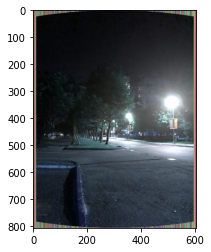

Process ForkPoolWorker-371:
Process ForkPoolWorker-374:
Process ForkPoolWorker-372:
Traceback (most recent call last):
Process ForkPoolWorker-375:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-373:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multip

Traceback (most recent call last):
  File "<ipython-input-44-d7c484351c6f>", line 100, in SIFT
    (kpsB, featuresB) = computeKeypointsAndDescriptors(img_right_gray)
  File "/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py", line 56, in computeKeypointsAndDescriptors
    descriptors = generateDescriptors(keypoints, gaussian_images)
  File "/home/309505001/DS/HW3/hw3-1/cpu_pool_main.py", line 400, in generateDescriptors
    descriptors = pool.starmap(descri,para_lst)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 274, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardIn

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", l

Error in callback <function flush_figures at 0x7fccaefabf28> (for post_execute):


KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process ForkPoolWorker-377:
Process ForkPoolWorker-379:
Process ForkPoolWorker-378:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    re

In [ ]:
%%prun -s cumulative -q -l 10 -T prun0
f = open('testfile.txt', 'r') #7:34
dirname_lst = f.readlines()
for d in range(len(dirname_lst)):
    dirname_lst[d] = str(dirname_lst[d]).strip()
print(dirname_lst)
#pool = Pool(6)#,maxtasksperchild=5000)
#result = pool.map(start,[dirname for dirname in dirname_lst])
for name in dirname_lst:
    start(name)
#start(dirname_lst[0])